In [7]:
%load_ext autoreload
%autoreload 2

from itertools import product
import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/')
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D
from PixelGen.metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pathlib import Path


import anndata as ad
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import train_model, get_model_latents
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA
from pixelator.common.statistics import clr_transformation, dsb_normalize


from pixelator.pna.plot import molecule_rank_plot
# from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
# from pixelator.statistics import c
# lr_transformation
# from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from PixelGen.pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from PixelGen.common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from PixelGen.metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D

import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl



# from cytovi import CytoVI

print(torch.cuda.is_available())
from sklearn.decomposition import PCA

from anndata import AnnData
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)

sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

from utils import plot_latent, plot_gene_heatmap, mask_adata, plot_model_latents
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"


Seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
Last run with scvi-tools version: 1.3.3


# SETUP

In [8]:
MODEL_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/models/'
ANNOTATED_ADATA_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/adata_annotated.h5ad'


adata=sc.read_h5ad(ANNOTATED_ADATA_PATH)
X_concat = np.concatenate([adata.layers["arcsinh"], adata.obsm["spatial_asinh"]], axis=1)

# PCA
tmp = AnnData(X_concat)
sc.pp.scale(tmp)
sc.tl.pca(tmp, n_comps=50)

# store back
adata.obsm["pca"] = tmp.obsm["X_pca"]

abundance_layer = 'arcsinh'
spatial_layer='spatial_asinh'
mask_adata(adata,spatial_key=spatial_layer)

Masked 233 cells (10.0%) — 116 set to 0.0, 117 set to 1000.0


# MASKED MODEL

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

Normal SCVI Model with the following params: 
n_latent: 30
n_modalities: 2
modalities: dict_keys(['arcsinh', 'spatial_asinh_masked'])
agg_method: aoe_global_weights
input_ds: [159, 12720]
modality indices: {'arcsinh': 0, 'spatial_asinh_masked': 1}
distributions: [<D.Normal: 1>, <D.Normal: 1>]
Training status: Trained

INFO     Using column names from columns of adata.obsm['spatial_asinh_masked']                                     


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scvi/train/_trainrunner.py:122: UserWarning: Training history cannot be updated. Logger can be accessed from `model.trainer.logger`
  self._update_history()


TypeError: 'NoneType' object is not subscriptable

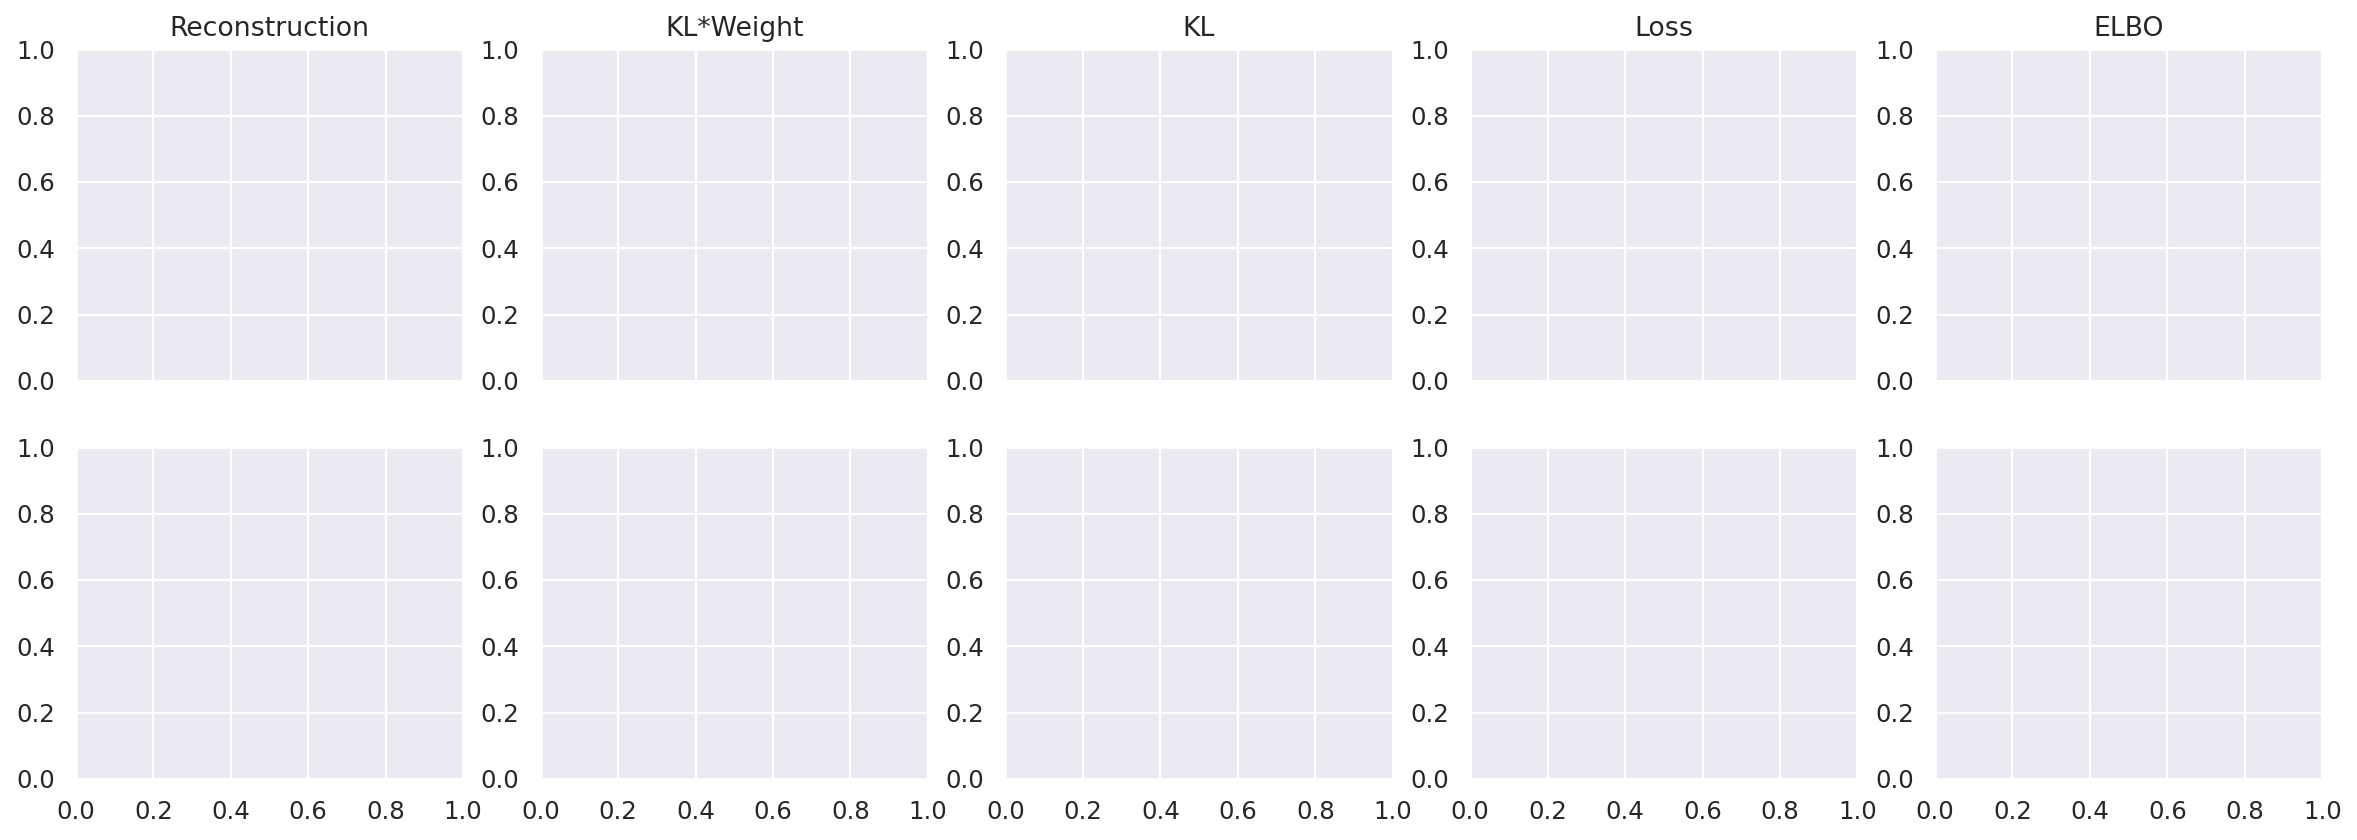

In [6]:
model_cls = MultiModalSCVI
abundance_layer = 'arcsinh'
spatial_layer='spatial_asinh_masked'
max_epochs=10000

setup_kwargs = dict(layer=abundance_layer, extra_modality_keys=[spatial_layer], n_modalities=2, batch_key='run', spatial_mask_key="spatial_masked",  )
model_kwargs = dict(n_latent=30, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                            distrs=[D.Normal, D.Normal], 
                            experts_method='POE',
                            loss_weights='auto',
                            joint_kl=False, unimodal_kl=True,
                            
                            decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp')
                        )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_patience=200, batch_size=2000,
                        max_epochs=max_epochs, enable_checkpointing=True, 
                        plan_kwargs=dict(lr=1e-4, optimizer='Adam', n_epochs_kl_warmup=400)
                    )
model = train_model(adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,)

In [6]:
model_name='masked_joint_encoders_POE'
model.save(f'{MODEL_PATH}{model_name}',overwrite=True)


# GENERATIVE AND LATENTS

In [9]:
model_name='masked_joint_encoders_POE'

model = MultiModalSCVI.load(f'{MODEL_PATH}{model_name}', adata=adata)
spatial_layer='spatial_asinh_masked'


INFO     File /home/projects/nyosef/zvise/PixelGen/PixelGen/models/masked_joint_encoders_POE/model.pt already      
         downloaded                                                                                                


In [10]:
imputed = model.get_normalized_expression(
    adata=adata,
    return_mean_expression=True,
    return_l2_error=True,
    return_px_distrs=False,
    return_numpy=True
)

In [33]:
spatial_layer

'spatial_asinh_masked'

In [52]:
masked_spatial_layer=f'{spatial_layer}_masked'

mask = adata.obs["spatial_masked"].values.astype(bool)

true_spatial = adata.obsm[spatial_layer].to_numpy()
imputed_spatial = imputed["exprs"][spatial_layer]

masked_true = true_spatial[mask, :]
masked_pred = imputed_spatial[mask, :]

unmasked_true = true_spatial[~mask, :]
unmasked_pred = imputed_spatial[~mask, :]

l2_masked = np.mean((masked_true - masked_pred) ** 2)
l2_unmasked = np.mean((unmasked_true - unmasked_pred) ** 2)

# Compute the ratio
ratio = l2_masked / (l2_unmasked + 1e-12)

print(f"Mean L2 reconstruction error (masked):     {l2_masked:.6f}")
print(f"Mean L2 reconstruction error (non-masked): {l2_unmasked:.6f}")
print(f"Ratio (masked / non-masked):               {ratio:.3f}")


Mean L2 reconstruction error (masked):     0.053958
Mean L2 reconstruction error (non-masked): 0.193052
Ratio (masked / non-masked):               0.279


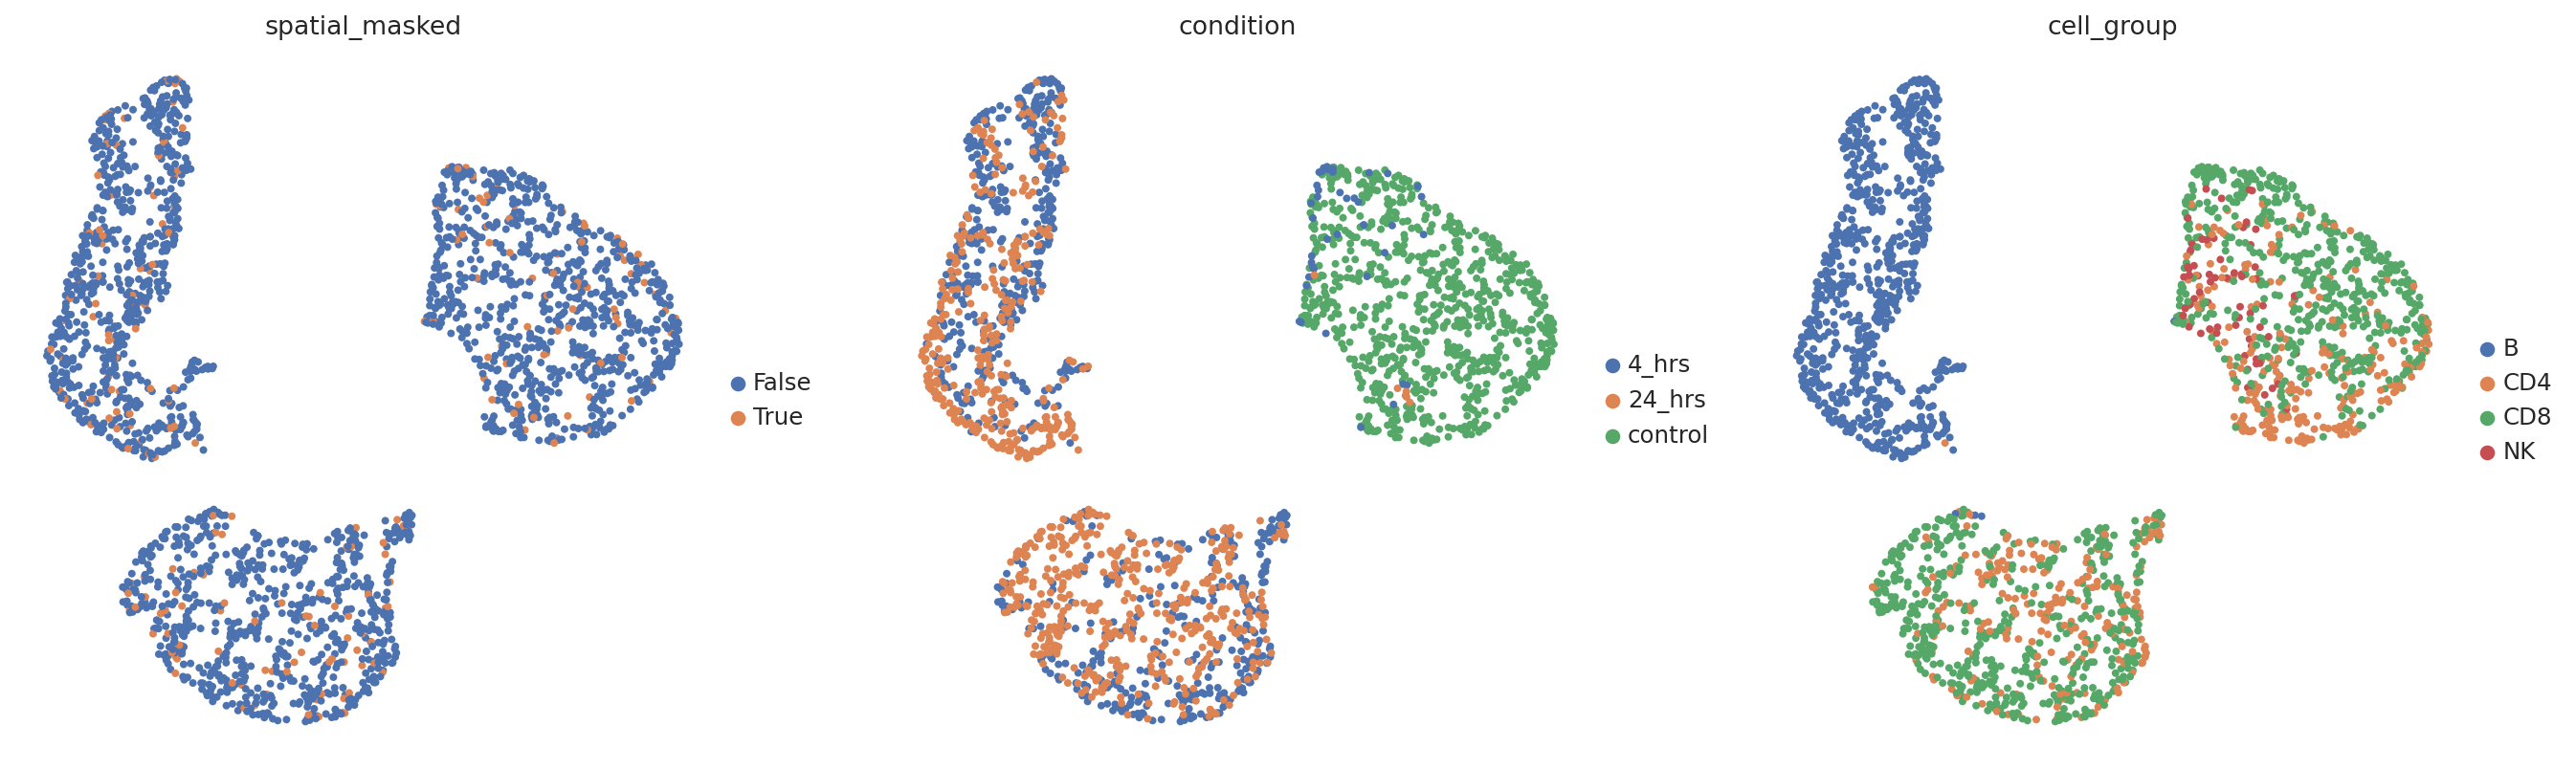

In [36]:
imputed_spatial = imputed["exprs"][spatial_layer]

adata_imputed = sc.AnnData(X=imputed_spatial, obs=adata.obs.copy())

adata_imputed.obs["spatial_masked"] = (
    adata_imputed.obs["spatial_masked"]
    .astype(bool)                
    .astype(str)                
    .astype("category")          
)

sc.pp.neighbors(adata_imputed, n_neighbors=15, use_rep="X")
sc.tl.umap(adata_imputed)
sc.pl.umap(
    adata_imputed,
    color=["spatial_masked",'condition','cell_group'],
)

/home/projects/nyosef/zvise/.local/share/mamba/envs/pxlgn/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


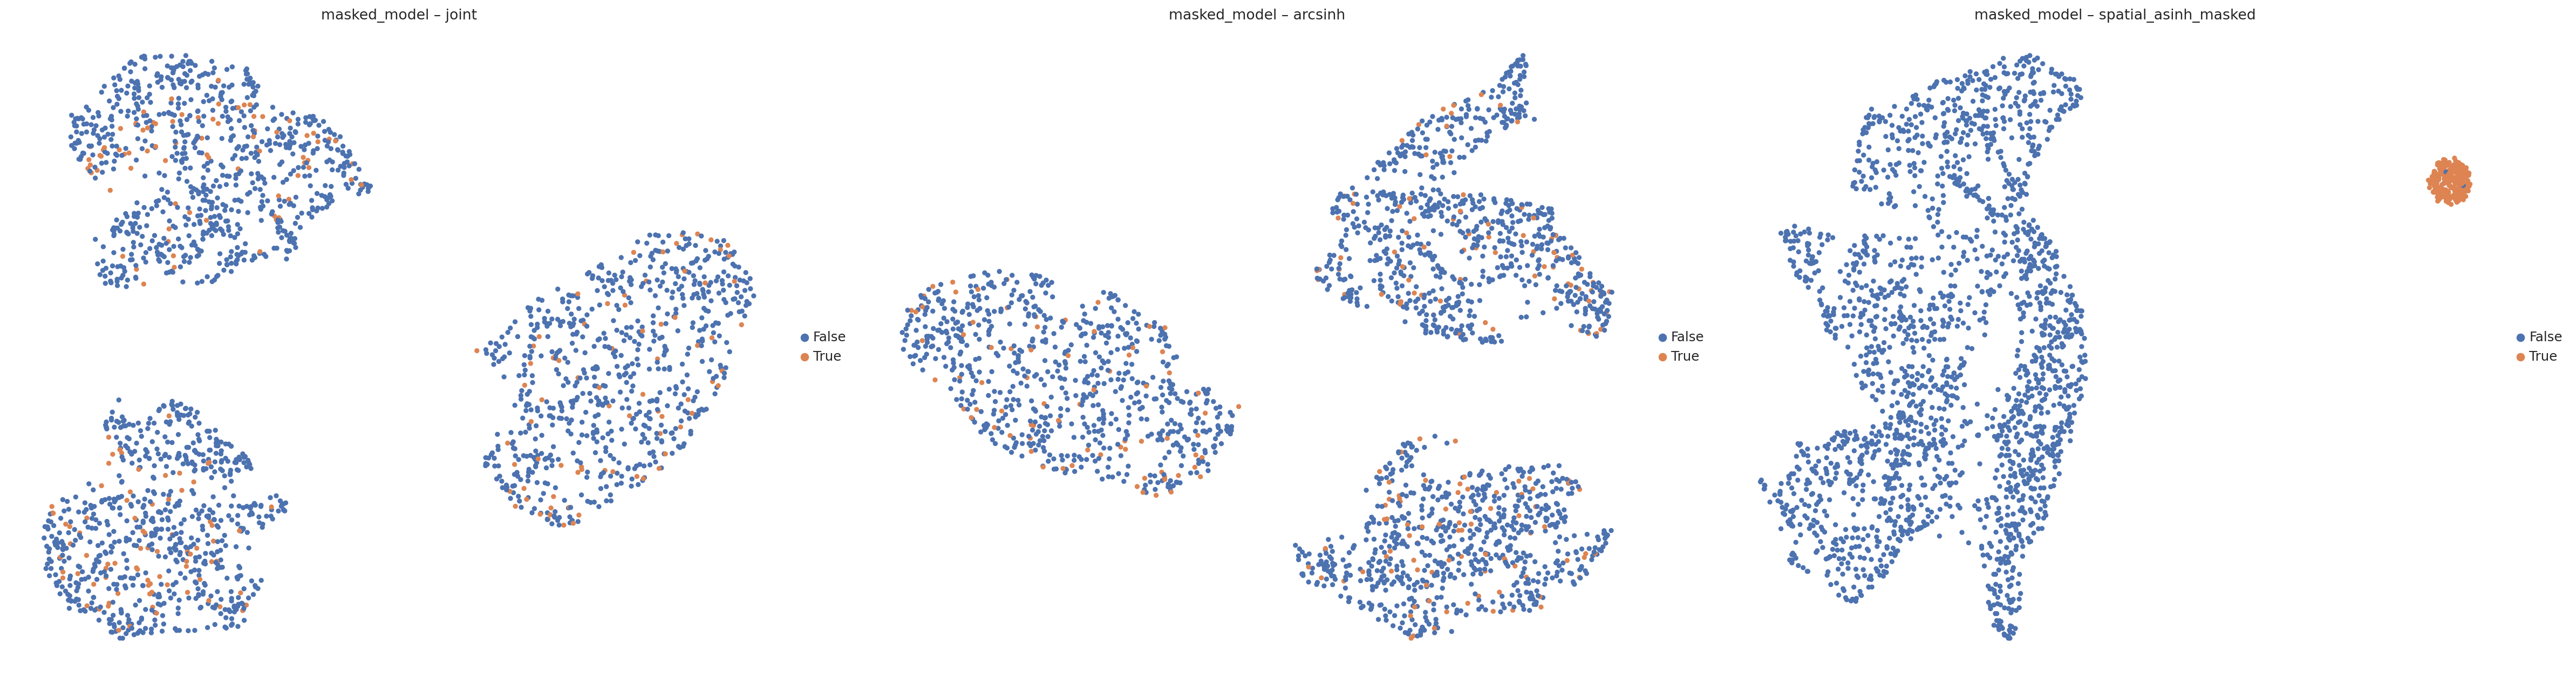

In [5]:
plot_model_latents({'masked_model':model},adata, color='spatial_masked')